# 2.2.3 Checking Normalization and Last Layer Reinitialization

The images didn't go through any kind of normalization when sent through the model, and the last layer should be reinitialized.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

Sat Sep 05 2020 16:24:47 

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-112-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit
host name  : serrep5
Git hash   : 51780b860c73fae4df359421a6c76fa3cb2ae7bb
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Conda Env


In [4]:
!conda list

/bin/bash: conda: command not found


## Imports

In [5]:
from pprint import pprint
import os
import numpy as np
from six.moves import cPickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import Iterator
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image, ImageOps

%aimport prevseg.index
import prevseg.index as index
%aimport prevseg.schapiro
import prevseg.schapiro as sch
from prevseg.schapiro import graph, walk
%aimport prevseg.constants
import prevseg.constants as const

%aimport prednet.kitti_settings
import prednet.kitti_settings as ks
%aimport prednet.prednet_base
import prednet.prednet_base as pn
%aimport prednet.data_utils
import prednet.data_utils as utils

# Keep track of versions of everything
%watermark -v -iv

Using TensorFlow backend.



matplotlib 3.3.1
numpy      1.19.1
prednet    0+untagged.74.g57d9b43
networkx   2.5
prevseg    0+untagged.71.g51780b8.dirty
PIL.Image  7.2.0
tensorflow 1.15.0
CPython 3.7.7
IPython 7.17.0


## Creating the Schapiro Datasets

In [6]:
batch_size = 14
n_pentagons = 3
max_steps = 100
n_paths = 1
source = 1

paths_data = list(index.DIR_SCH_FRACTALS_RS.iterdir())
np.random.shuffle(paths_data)
paths_data = paths_data[:5*n_pentagons]
array_data = np.array([np.load(str(path)) for path in paths_data])

G = sch.graph.schapiro_graph(n_pentagons=n_pentagons)

mapping = {node : path.stem for node, path in zip(range(len(G.nodes)), paths_data)}

In [7]:
def iter_single_sample(G, mode, max_steps, source=None): 
    if mode == 'random':
        iter_walk = sch.walk.walk_random(G, steps=max_steps, source=source)
    elif mode == 'euclidean':
        iter_walk = sch.walk.walk_euclidean(G, source=source)
    elif mode == 'hamiltonian':
        iter_walk = sch.walk.walk_hamiltonian(G, source=source)
    else:
        raise ValueError('Invalid mode entered')

    for sample in iter_walk:
        yield array_data[sample[0]], sample[0]

def iter_batch_sample(G, mode, max_steps, batch_size, source=None):
    iter_batch = zip(*[iter_single_sample(G, mode, max_steps, source=source) 
                       for _ in range(batch_size)])
    for batch in iter_batch:
        data, nodes = zip(*batch)
        yield data, nodes

def iter_batch_dataset(G, mode, max_steps, batch_size, n_paths, source=None):       
    for _ in range(n_paths):
        data, nodes = zip(*list(iter_batch_sample(
            G, mode, max_steps, batch_size, source=source)))
        yield np.moveaxis(np.array(data), 0, 1), nodes

fine_tune_data_iter = iter_batch_dataset(G, 'random', max_steps, batch_size, n_paths)
fine_tune_data, fine_tune_nodes = next(fine_tune_data_iter)
fine_tune_data.shape

(14, 100, 3, 128, 160)

### Testing Dataset

In [8]:
euclidean_iter = iter_batch_dataset(G, 'euclidean', None, 1, n_paths, source=source)
_, euclidean_nodes = next(euclidean_iter)

In [9]:
euclidean_nodes = list(np.array(euclidean_nodes).reshape(30))
euclidean_nodes

[1,
 4,
 3,
 2,
 4,
 5,
 8,
 9,
 7,
 8,
 6,
 7,
 5,
 6,
 9,
 10,
 13,
 14,
 12,
 13,
 11,
 12,
 10,
 11,
 14,
 0,
 3,
 1,
 2,
 0]

In [10]:
# Inlcude some non-important steps the start to allow the hidden state to adapt
initial_padding = [1,0,1,0,1,0]
test_walk_nodes = initial_padding + euclidean_nodes

test_data = np.expand_dims(np.array([array_data[n] for n in test_walk_nodes]),0)
test_data.shape

(1, 36, 3, 128, 160)

### Using Sequence Generators

In [11]:
class ShapiroFractalsDataset(Iterator):
    modes = set(('random', 'euclidean', 'hamiltonian'))
    def __init__(self, batch_size=32, n_pentagons=3, max_steps=128, n_paths=128,
                 mapping=None, mode='random', debug=False, seed=None, shuffle=False):
        self.batch_size = batch_size
        self.n_pentagons = n_pentagons
        self.max_steps = max_steps
        self.n_paths = n_paths
        self.mapping = mapping
        self.mode = mode
        self.debug = debug
        assert self.mode in self.modes
        
        self.G = graph.schapiro_graph(n_pentagons=n_pentagons)
        
        self.load_node_stimuli()
        
        self.mapping = {node : path.stem
                        for node, path in zip(range(len(self.G.nodes)),
                                              self.paths_data)}
        print(f'Created mapping as follows:\n{self.mapping}')
        
        if self.debug:
            self.sample_transform = lambda sample : sample
        else:
            self.sample_transform = lambda sample : self.array_data[sample]
        super().__init__(self.n_paths, self.batch_size, shuffle, seed)
        
    def load_node_stimuli(self):
        # Load the fractal images into memory
        assert index.DIR_SCH_FRACTALS_RS.exists()
        if self.mapping:
            self.paths_data = [index.DIR_SCH_FRACTALS_RS / (name+'.npy')
                               for name in self.mapping.values()]
        else:
            paths_data = list(index.DIR_SCH_FRACTALS_RS.iterdir())
            np.random.shuffle(paths_data)
            self.paths_data = paths_data[:5*self.n_pentagons]
        self.array_data = np.array([np.load(str(path)) for path in self.paths_data])
        self.array_data = self.array_data - np.array(const.IMAGENET_NORM_MEAN).reshape((1,3,1,1))
        self.array_data = self.array_data / np.array(const.IMAGENET_NORM_STD).reshape((1,3,1,1))
        
    def iter_single_sample(self): 
        if self.mode == 'random':
            iter_walk = sch.walk.walk_random(self.G, steps=self.max_steps)
        elif self.mode == 'euclidean':
            iter_walk = sch.walk.walk_euclidean(self.G)
        elif self.mode == 'hamiltonian':
            iter_walk = sch.walk.walk_hamiltonian(self.G)

        for sample in iter_walk:
            yield self.array_data[sample[0]], sample[0]
        
    def iter_batch_sample(self):
        iter_batch = zip(*[self.iter_single_sample()
                           for _ in range(self.batch_size)])
        for batch in iter_batch:
            data, nodes = zip(*batch)
            yield data, nodes
        
    def iter_batch_dataset(self):   
        for _ in range(self.n_paths):
            data, nodes = zip(*list(self.iter_batch_sample()))
            yield np.moveaxis(np.array(data), 0, 1), nodes
        
    def __iter__(self):
        return self.iter_batch_dataset()
    
    def __getitem__(self, null):
        data_iter = self.iter_batch_dataset()
        data = next(data_iter)[0]
        data2 = np.zeros(data.shape)
        data2[:,:-1,:,:,:] = data[:,1:,:,:,:]
        return data, data2
    
max_steps = 100
epochs = 1
batch_size = 14
n_paths = 1

iter_ds = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                 mapping=mapping)
for _ in range(epochs):
    for i, batch in enumerate(iter_ds):
        print(i, batch[0].shape)
        if i == max_steps:
            print('bad')
            break

Created mapping as follows:
{0: '40', 1: '15', 2: '91', 3: '29', 4: '22', 5: '99', 6: '79', 7: '19', 8: '45', 9: '85', 10: '56', 11: '24', 12: '71', 13: '77', 14: '21'}
0 (14, 100, 3, 128, 160)


In [12]:
iter_ds.array_data.shape

(15, 3, 128, 160)

## Reinitializing the Readout Layer

In [35]:
nt = fine_tune_data.shape[1]
orig_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights.hdf5')  # original t+1 weights
orig_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model.json')

fractals_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights-fractals_finetuned.hdf5')  # where new weights will be saved
fractals_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model-fractals_finetuned.json')

In [66]:
save_model = True
nb_epoch = 1500
batch_size = 3
samples_per_epoch = None
N_seq_val = 50  # number of sequences to use for validation
max_steps = 50
n_paths = 60
nt = max_steps

# Load t+1 model
f = open(orig_json_file, 'r')
json_string = f.read()
f.close()
orig_model = model_from_json(json_string, custom_objects = {'PredNet': pn.PredNet})
orig_model.load_weights(orig_weights_file)

In [67]:
readout_weights = [(i, w) for i, w in 
                   enumerate(orig_model.layers[1].trainable_weights) 
                   if 'ahat_0' in w.name]
readout_weights

[(6,
  <tf.Variable 'prednet_1_10/layer_ahat_0/kernel:0' shape=(3, 3, 3, 3) dtype=float32>),
 (7,
  <tf.Variable 'prednet_1_10/layer_ahat_0/bias:0' shape=(3,) dtype=float32>)]

In [68]:
orig_weights = orig_model.layers[1].get_weights()
assert all([np.all(w1 == w2) for w1, w2 in
            zip(orig_model.layers[1].get_weights(), orig_weights)])

In [69]:
for i, w in readout_weights:
    new_w = np.random.rand(*w.shape.as_list())*np.sqrt(1/(sum(w.shape.as_list())))
    assert new_w.shape == w.shape
    orig_weights[i] = new_w

In [70]:
assert not all([np.all(w1 == w2) for w1, w2 in 
                zip(orig_model.layers[1].get_weights(), orig_weights)])

In [71]:
layer_config = orig_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
prednet = pn.PredNet(weights=orig_weights, **layer_config)

## Learning Rate Multipliers

In [72]:
# See https://erikbrorson.github.io/2018/04/30/Adam-with-learning-rate-multipliers/
from keras.legacy import interfaces
import keras.backend as K
from keras.optimizers import Optimizer

class Adam_lr_mult(Optimizer):
    """Adam optimizer.
    Adam optimizer, with learning rate multipliers built on Keras implementation
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        
    AUTHOR: Erik Brorson
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False,
                 multipliers=None, debug_verbose=False,**kwargs):
        super(Adam_lr_mult, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.multipliers = multipliers
        self.debug_verbose = debug_verbose

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.learning_rate
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):

            # Learning rate multipliers
            if self.multipliers:
                multiplier = [mult for mult in self.multipliers if mult in p.name]
            else:
                multiplier = None
            if multiplier:
                new_lr_t = lr_t * self.multipliers[multiplier[0]]
                if self.debug_verbose:
                    print('Setting {} to learning rate {}'.format(multiplier[0], new_lr_t))
                    print(K.get_value(new_lr_t))
            else:
                new_lr_t = lr_t
                if self.debug_verbose:
                    print('No change in learning rate {}'.format(p.name))
                    print(K.get_value(new_lr_t))
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - new_lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - new_lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.learning_rate)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad,
                  'multipliers':self.multipliers}
        base_config = super(Adam_lr_mult, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [73]:
learning_rate_multipliers =  {w.name : 0.001 for w in orig_model.layers[1].trainable_weights}
for i, w in readout_weights:
    learning_rate_multipliers[w.name] = 1

adam_lr_mult = Adam_lr_mult(multipliers=learning_rate_multipliers)

In [74]:
input_shape = list(orig_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt

inputs = Input(input_shape)
predictions = prednet(inputs)
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mse', optimizer=adam_lr_mult)

## Training the Model

In [ ]:
train_generator = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                    mapping=mapping)

lr_schedule = lambda epoch: 0.001 if epoch < nb_epoch/2 else 0.0001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
callbacks = [LearningRateScheduler(lr_schedule)]
if save_model:
    if not ks.WEIGHTS_DIR.exists(): 
        ks.WEIGHTS_DIR.mkdir(parents=True)
    callbacks.append(ModelCheckpoint(filepath=fractals_weights_file, monitor='loss', save_best_only=True))
history = model.fit_generator(train_generator, samples_per_epoch, nb_epoch, callbacks=callbacks,
                validation_data=None)

if save_model:
    json_string = model.to_json()
    with open(fractals_json_file, "w") as f:
        f.write(json_string)

Created mapping as follows:
{0: '40', 1: '15', 2: '91', 3: '29', 4: '22', 5: '99', 6: '79', 7: '19', 8: '45', 9: '85', 10: '56', 11: '24', 12: '71', 13: '77', 14: '21'}
Epoch 1/1500
20/20 [==============================] - 43s 2s/step - loss: 254154.8742
Epoch 2/1500
20/20 [==============================] - 33s 2s/step - loss: 254351.0062
Epoch 3/1500
13/20 [==================>...........] - ETA: 11s - loss: 254940.1911

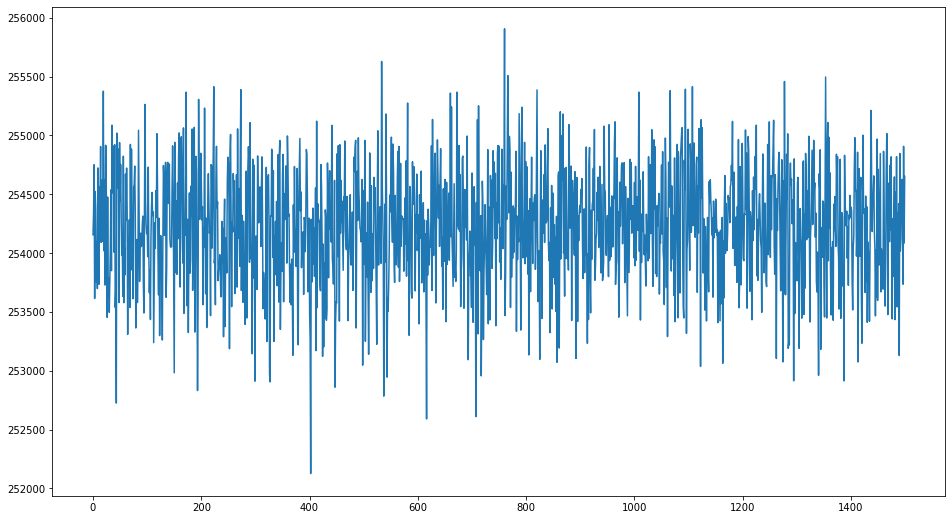

In [77]:
plt.plot(history.history['loss'])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

## Testing Representations

In [78]:
nt = 36
# Create testing model (to output predictions)
layer_config = model.layers[1].get_config()
X_Rs = []

for i in range(len(layer_config['R_stack_sizes'])):

    layer_config['output_mode'] = 'R' + str(i)
    data_format = layer_config['data_format'] if 'data_format' in layer_config \
        else layer_config['dim_ordering']
    test_prednet = pn.PredNet(weights=model.layers[1].get_weights(), 
                              **layer_config)

    input_shape = list(model.layers[0].batch_input_shape[1:])
    input_shape[0] = nt
    inputs = Input(shape=tuple(input_shape))
    R_outs = test_prednet(inputs)
    test_model = Model(inputs=inputs, outputs=R_outs)

    X_Rs.append(test_model.predict(test_data, batch_size))

In [79]:
X_Rs[1][0].shape

(36, 48, 64, 80)

In [80]:
for i, node in enumerate(test_walk_nodes):
    print(i, node)

0 1
1 0
2 1
3 0
4 1
5 0
6 1
7 4
8 3
9 2
10 4
11 5
12 8
13 9
14 7
15 8
16 6
17 7
18 5
19 6
20 9
21 10
22 13
23 14
24 12
25 13
26 11
27 12
28 10
29 11
30 14
31 0
32 3
33 1
34 2
35 0


In [81]:
borders = [10, 20, 30]

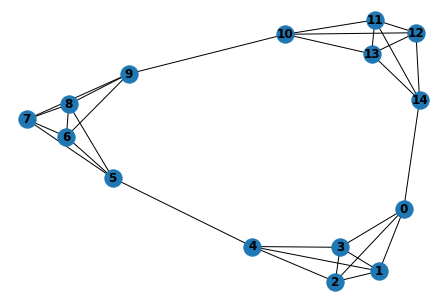

In [82]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [83]:
diffs_Rs = []
for i in range(len(X_Rs)):
    diffs_Rs.append(np.mean(np.diff(X_Rs[i][0], axis=0)**2, axis=(1,2,3)))

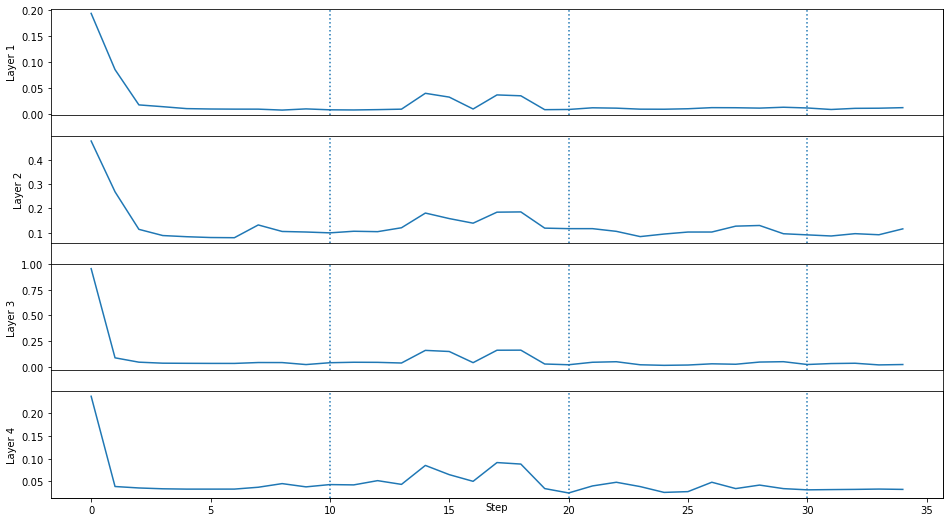

In [84]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, diff_R in enumerate(diffs_Rs):
    ax = fig.add_subplot(11 + i + len(diffs_Rs)*100)
    ax.plot(diff_R)
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i != len(diffs_Rs)-1:
        ax.axes.xaxis.set_ticks([])
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
ax_large.set_xlabel('Step')
gcf = plt.gcf()
gcf.set_size_inches(16,9)